In [1]:
%pip install torch torchvision timm scikit-learn matplotlib Pillow opencv-python solo-learn


  Using cached solo_learn-1.0.2-py3-none-any.whl.metadata (1.1 kB)
INFO: pip is looking at multiple versions of solo-learn to determine which version is compatible with other requirements. This could take a while.
  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
INFO: pip is still looking at multiple versions of solo-learn to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached torch-2.6.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached torch-2.0.0-cp311-cp311-win_amd64.whl.metadata (24 kB)

The conflict is caused by:
    The user requested torch
    torchvision 0.15.1 depends on torch==2.0.0
    timm 0.1.1 depends o

ERROR: Cannot install solo-learn==1.0.2, timm==0.1.1, torch and torchvision==0.15.1 because these package versions have conflicting dependencies.

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [2]:
# 🔧 2. Imports
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timm import create_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 🧠 3. Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# 📁 4. Define Data Directory
data_dir = "./data"  # Make sure this contains train/val/test with fire/no-fire

# 🔄 5. Transforms
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
# 📊 6. Load Datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)
val_data   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_test)
test_data  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['fire', 'nofire']


In [9]:
# 🧠 7. Load Pretrained ViT
from timm import create_model
model = create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

c:\Users\Lenovo\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--timm--vit_tiny_patch16_224.augreg_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [10]:
# 🔁 8. Training Function
def train(model, loader):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [11]:
# 🧪 9. Evaluation Function
def evaluate(model, loader, title="Validation"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)
    print(f"📈 {title} Results")
    print(classification_report(all_labels, all_preds, target_names=class_names))


In [12]:
# Freeze all except classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

# Faster training loop
for epoch in range(3):  # reduced from 5
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
    evaluate(model, val_loader)

# Save
torch.save(model.state_dict(), 'vit_forest_fire.pth')


Epoch 1, Loss: 0.5953
📈 Validation Results
              precision    recall  f1-score   support

        fire       0.88      0.94      0.91       250
      nofire       0.92      0.83      0.87       191

    accuracy                           0.89       441
   macro avg       0.90      0.89      0.89       441
weighted avg       0.90      0.89      0.89       441

Epoch 2, Loss: 0.3618
📈 Validation Results
              precision    recall  f1-score   support

        fire       0.91      0.98      0.94       250
      nofire       0.97      0.87      0.92       191

    accuracy                           0.93       441
   macro avg       0.94      0.92      0.93       441
weighted avg       0.93      0.93      0.93       441

Epoch 3, Loss: 0.2968
📈 Validation Results
              precision    recall  f1-score   support

        fire       0.92      0.98      0.95       250
      nofire       0.98      0.89      0.93       191

    accuracy                           0.94       441

In [13]:
from sklearn.metrics import accuracy_score

def test_accuracy(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Test Accuracy: {acc * 100:.2f}%")
    return acc

In [14]:
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [15]:
test_accuracy(model, test_loader)

✅ Test Accuracy: 94.82%


0.9481981981981982

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21044\545562571.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vit_forest_fire.pth', map

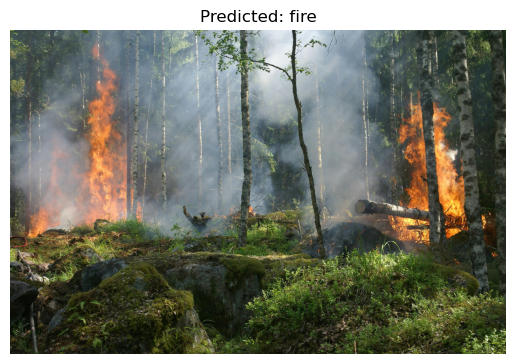

In [24]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from timm import create_model
import os

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Recreate same model
model = create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('vit_forest_fire.pth', map_location=device))
model = model.to(device)
model.eval()

# ✅ Use same transform as in validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load a sample image from val set (change path if needed)
img_path = 'data/val/pexels-pixabay-51951.jpg'  # <- Change to any image in val/fire or val/no-fire
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# 🔍 Inference
with torch.no_grad():
    output = model(input_tensor)
    predicted = torch.argmax(output, dim=1).item()

# 🔤 Decode prediction
class_names = ['fire', 'no-fire']
label = class_names[predicted]

# 🖼️ Show image with prediction
plt.imshow(img)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()

In [25]:
%pip install git+https://github.com/jacobgil/vit-explain



  Cloning https://github.com/jacobgil/vit-explain to c:\users\lenovo\appdata\local\temp\pip-req-build-5v1i2zp7
  Resolved https://github.com/jacobgil/vit-explain to commit 15a81d355a5aa6128ea4e71bbd56c28888d0f33b


  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/vit-explain 'C:\Users\Lenovo\AppData\Local\Temp\pip-req-build-5v1i2zp7'

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: git+https://github.com/jacobgil/vit-explain does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


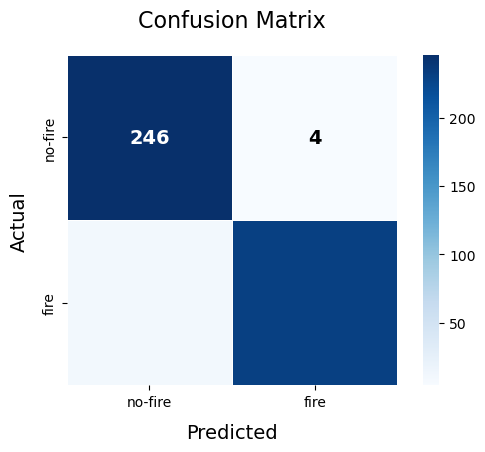

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Replace with your actual confusion matrix
cm = np.array([[246, 4],
               [10, 231]])

class_names = ['no-fire', 'fire']

plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names,
                 cbar=True, square=True, linewidths=0.5, annot_kws={"fontsize": 14, "weight": "bold"})

# Dynamically set text color
for text in ax.texts:
    value = int(text.get_text())
    row, col = map(int, text.get_position())
    if cm[row][col] > (cm.max() * 0.6):
        text.set_color("white")
    else:
        text.set_color("black")

# Axis and title formatting
plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.title('Confusion Matrix', fontsize=16, pad=20)

# ✅ FIX: Adjust layout to avoid cutting off bottom labels
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leaves more bottom margin

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix values
cm = np.array([[246, 4],
               [10, 231]])

class_names = ['no-fire', 'fire']

fig, ax = plt.subplots(figsize=(6, 6))  # Make it square
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True, linewidths=0.5, ax=ax)

# Manually add annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = 'white' if value > (cm.max() * 0.6) else 'black'
        ax.text(j + 0.5, i + 0.5, str(value),
                ha='center', va='center', color=color, fontsize=14, weight='bold')

# Labels and title
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Actual', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16, pad=20)

# Fix layout and padding
plt.tight_layout()
plt.show()
